<a href="https://colab.research.google.com/github/harmanpreet93/reinforcement-learning-COMP-767/blob/master/Multi_Armed_Bandits_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
class BanditMachine():
  def __init__(self):
    self.actions_means = np.random.normal(0, 1, size=(10,))
    self.data = [np.random.normal(m, 1, size=1000) for m in self.actions_means]
    self.init_actions_means = self.actions_means

  def reset(self):
    self.actions_means = self.init_actions_means

  def get_reward(self, arm):
    return np.random.normal(self.actions_means[arm], 1)

  def plot(self):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
    axes.violinplot(self.data, [i for i in range(1,11)], points=200, widths=0.4, showmeans=True,
                    showextrema=True, showmedians=False, bw_method=0.5)

    ## Formatting
    axes.axhline(y=0., color='grey', linestyle='--')
    axes.set_xlabel("Action", fontweight='bold', fontsize=12)
    axes.set_xticks([i for i in range(1,11)])
    axes.set_yticks([4,3,2,1,0,-1,-2,-3,-4])
    axes.set_ylabel("Reward distribution", fontweight='bold', fontsize=12)
    axes.grid(True, color="lightgrey")
    plt.show()

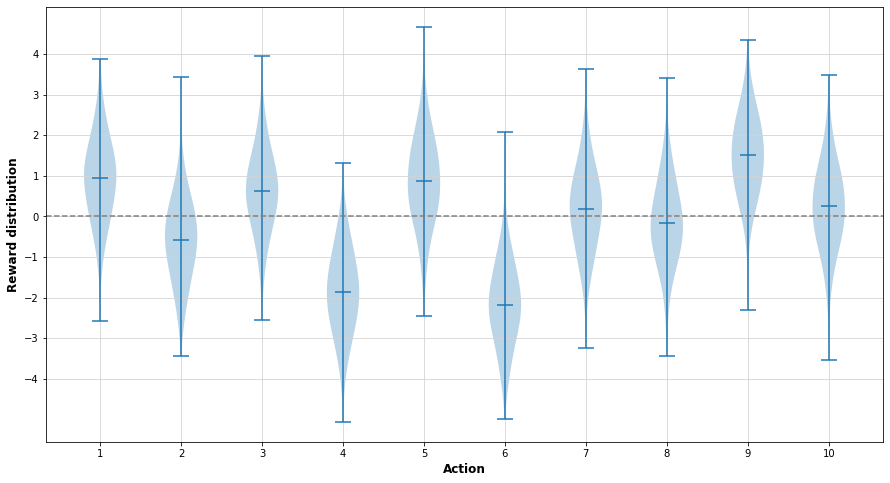

In [0]:
bandit = BanditMachine()
bandit.plot()

In [0]:
def algo_new(bandit: BanditMachine, algo, param, max_steps=1000):
  action_values = np.zeros(shape=(10,), dtype=np.float)
  action_n_t = np.ones(shape=(10,), dtype=np.int)
  regret_log = []
  reward_log = []
  optimal_action = np.argmax(bandit.actions_means)

  # Required for Thompson Sampling
  mu      = np.zeros(10)
  sigma2  = np.ones(10) * 1000
  test_avg_reward = []
  for t in range(1, max_steps):
    if algo=="ucb":
      c = param
      a_t = np.argmax(action_values + c*np.sqrt(np.log(t)/action_n_t))
      r_t = bandit.get_reward(a_t)

    elif algo == "thompson":
      sigma = param
      params = np.random.normal(loc=mu, scale=np.sqrt(sigma2))

      # a_t = np.random.choice(np.where(params == params.max())[0])  #adding randomness in np.argmax(params)
      a_t = np.argmax(params)
      r_t = bandit.get_reward(a_t)

      # update [posterior] distribution ## Can modify it 
      sigma2_tmp      = 1. / ( (1./sigma2[a_t]) + (1./(sigma)) )
      mu[a_t]      = sigma2_tmp * ( (mu[a_t]/sigma2[a_t]) + (r_t/(sigma)) )
      sigma2[a_t]  = sigma2_tmp

    elif algo == "softmax":
      temp = param
      e_x = np.exp(action_values/temp)
      prob = e_x/e_x.sum()
      a_t = np.random.choice( [i for i in range(10)], 1,  p=prob)
      r_t = bandit.get_reward(a_t)

    elif algo == "e-greedy":
      e = param
      random_num = np.random.uniform()
      if random_num < e: a_t = np.random.randint(low=0, high=10)
      else: a_t = np.argmax(action_values)
      r_t = bandit.get_reward(a_t)

    elif algo == "greedy":
      a_t = np.argmax(action_values)
      r_t = bandit.get_reward(a_t)

    else:
      return "Incorrect Algorithm"


    if t%10==0:
      if algo=="thompson":
        a_t = np.argmax(mu)
      else:
        a_t = np.argmax(action_values)
      avg_r_t = 0
      for i in range(5):
        avg_r_t += bandit.get_reward(a_t)
      test_avg_reward.append(avg_r_t/5)

    action_n_t[a_t] += 1
    reward_log.append(r_t)
    regret_log.append(bandit.actions_means[optimal_action] - r_t)

    # Updating Reward: New Estimate <- Old Estimate + Step Size [Target - Old Estimate]
    action_values[a_t] = action_values[a_t] + (1/action_n_t[a_t])*(r_t - action_values[a_t])
    
  return np.array(reward_log), np.array(regret_log), np.array(test_avg_reward)


In [0]:
def hyparam_search(algo, params, iter = 100):
  dic = {}
  bandit = BanditMachine()
  for param in params:
    count = 0
    reward_log_list, regret_log_list, test_avg_reward_list = [], [], []
    while(count<iter):
      count+=1
      reward_log, regret_log, test_avg_reward = algo_new(bandit, algo=algo, param=param, max_steps=1000)
      reward_log_list.append(reward_log)
      regret_log_list.append(regret_log)
      test_avg_reward_list.append(test_avg_reward)
    dic[algo+"_"+str(param)] = [reward_log_list, regret_log_list, test_avg_reward_list]
  return dic

def plot(algo, params, dic):
  fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(17,15))
  avg_regret, avg_reward = [], []
  for keys, value in dic.items():
    ax1.plot(np.array(value[0]).mean(axis=0))
    ax2.plot(np.array(value[1]).mean(axis=0))
    ax3.plot(np.array(value[2]).mean(axis=0))
    avg_reward.append(np.array(value[0]).mean(axis=1).mean(axis=0))
    avg_regret.append(np.array(value[1]).mean(axis=1).mean(axis=0))
#   ax4.plot(params)
  ax1.legend(labels=params, loc="lower right");
  ax2.legend(labels=params, loc="lower right");
  ax3.legend(labels=params, loc="lower right");
  ax1.set_ylabel("Training Average Reward");
  ax2.set_ylabel("Training Average Regret");
  ax3.set_ylabel("Testing Average Reward");


We perform hyperparameter search in Boltzmann (Softmax), UCB and Thomson sampling algorithms to find optimal hyperparams. We find the best average test rewards in Softmax comes at temperature=0.1, at sigma=0.5 in Thompson sampling and c=0.5 in UCB sampling. Following plots demonstrates the average training and test reward, as well as average training regret on all three algorithms.

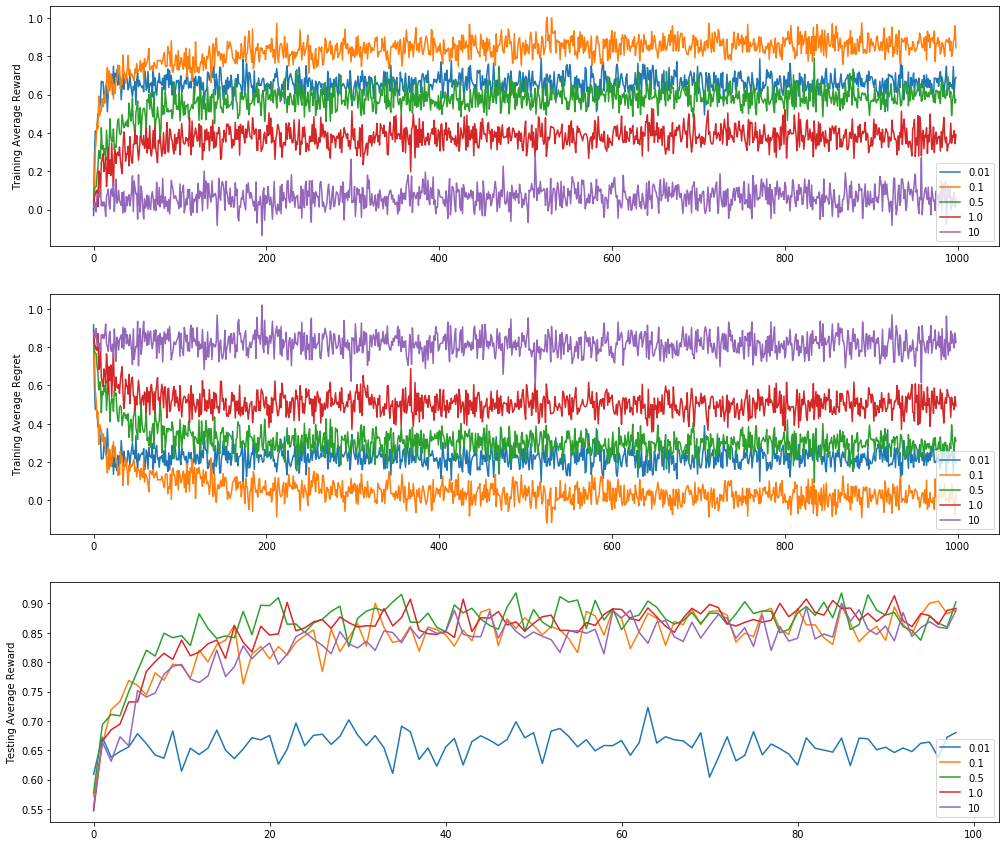

In [0]:
algorithm = "softmax"
params = [0.01, 0.1, 0.5, 1.0, 10]
dict_softmax = hyparam_search(algo=algorithm, params=params, iter = 500)
plot(algorithm, params, dict_softmax)

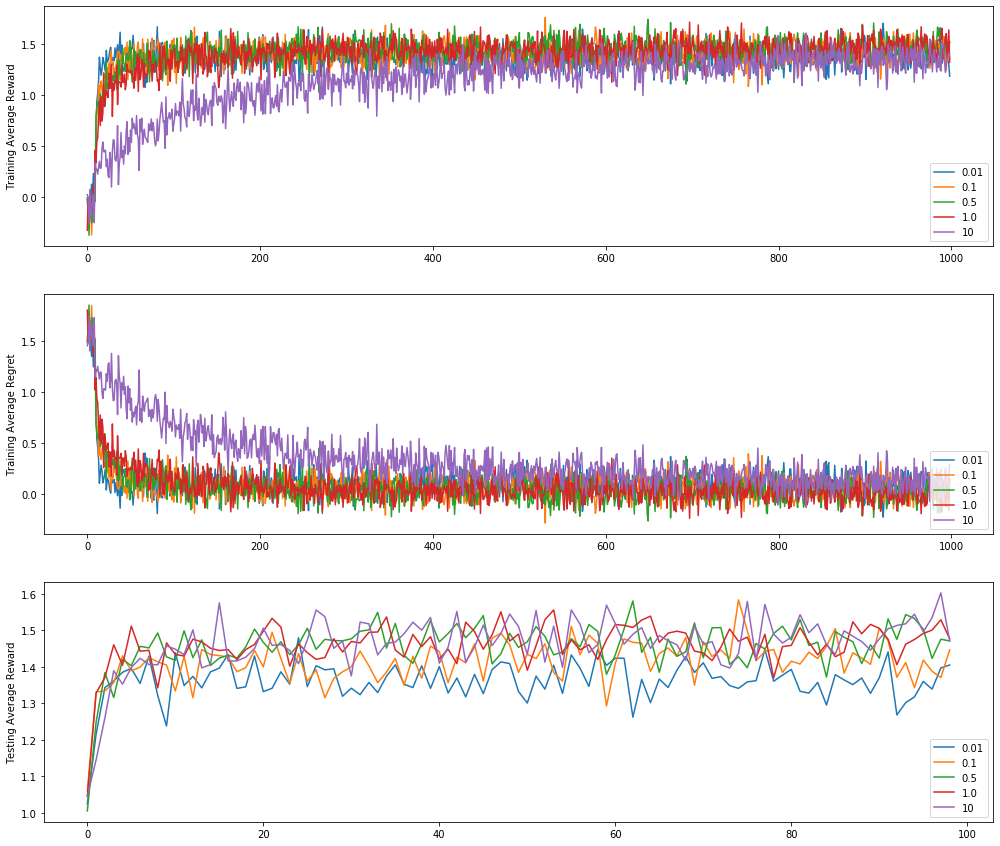

In [0]:
algorithm = "thompson"
params = [0.01, 0.1, 0.5, 1.0, 10]
dict_thompson = hyparam_search(algo=algorithm, params=params, iter = 500)
plot(algorithm, params, dict_thompson)

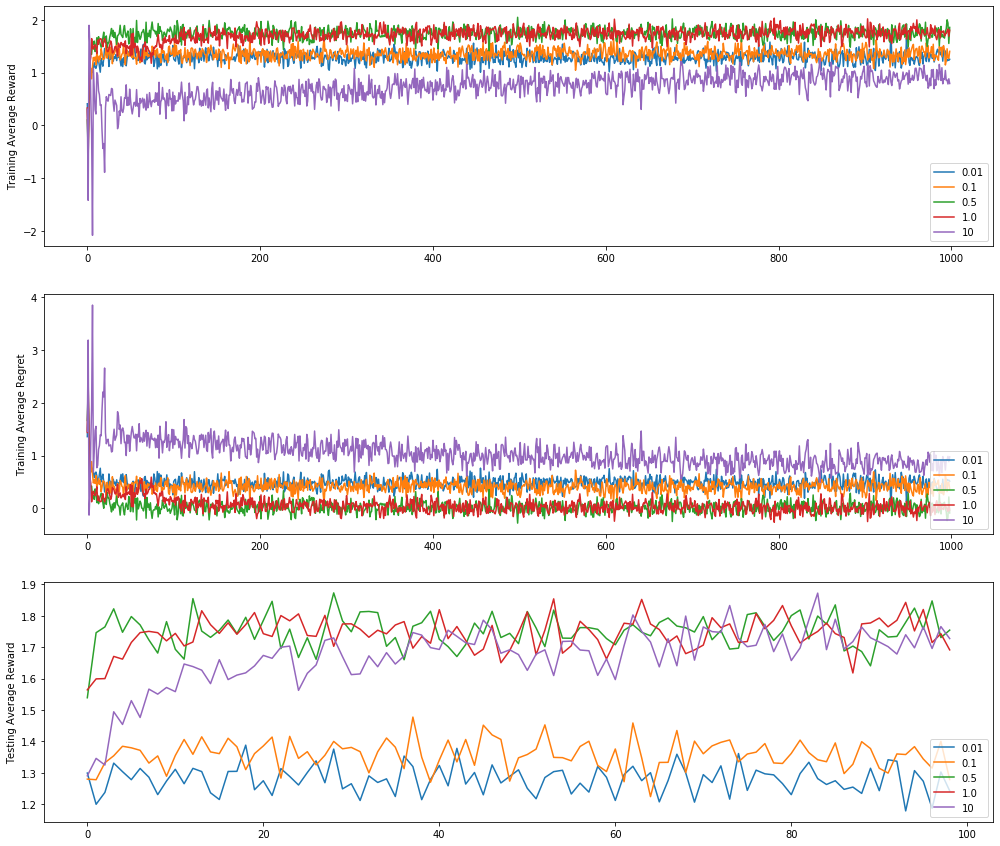

In [0]:
algorithm = "ucb"
params = [0.01, 0.1, 0.5, 1.0, 10]
dict_ucb = hyparam_search(algo=algorithm, params=params, iter = 500)
plot(algorithm, params, dict_ucb)

In [0]:
max_steps = 1000
z = 0 
C,G,K,O,S = [],[],[],[],[]
D,H,L,P,T = [],[],[],[],[]
t1, t2, t3, t4, t5 = [], [], [], [], []
bandit = BanditMachine()
while(z<=10):
  c,d,test1 = algo_new(bandit, algo="ucb", param=0.5, max_steps=max_steps)
  g,h,test2 = algo_new(bandit, algo="thompson", param=0.5, max_steps=max_steps)
  k,l,test3 = algo_new(bandit, algo="softmax", param=0.1, max_steps=max_steps)
  o,p,test4 = algo_new(bandit, algo="e-greedy", param=0.05, max_steps=max_steps)
  s,t,test5 = algo_new(bandit, algo="greedy", param=None, max_steps=max_steps)

  C.append(c);G.append(g);K.append(k);O.append(o);S.append(s)
  D.append(d);H.append(h);L.append(l);P.append(p);T.append(t)
  t1.append(test1);t2.append(test2);t3.append(test3); t4.append(test4); t5.append(test5)

  z+=1 

We run multiple experiments on different experiments and analyze best bandit algorithm based on test average rewards. While we show our results on just 10 runs as requested in the question, we investigated the algorithm performace by running 1000 independent runs as well. 

We expected Thomson sampling algorithm to work the best as it utilized prior distribution, but we found UCB and Thompson working equally good, and better than Softmax. 

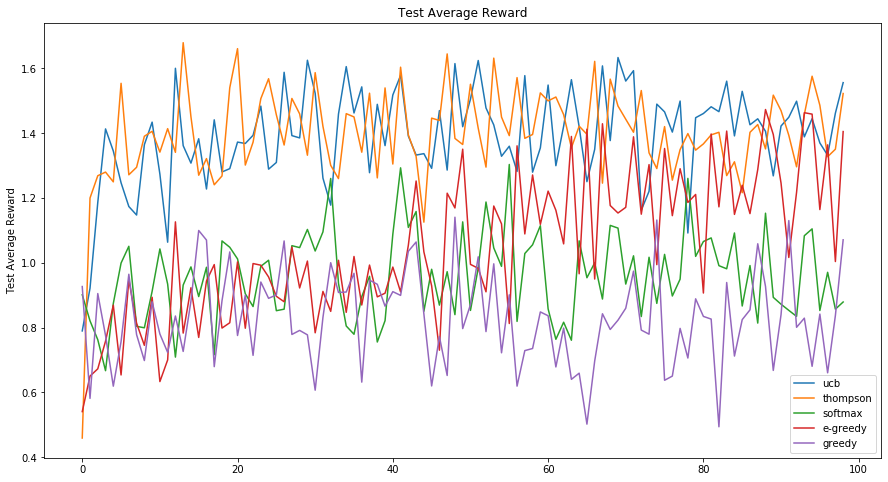

In [0]:
plt.figure(figsize=(15,8))
plt.plot(np.array(t1).mean(axis=0))
plt.plot(np.array(t2).mean(axis=0))
plt.plot(np.array(t3).mean(axis=0))
plt.plot(np.array(t4).mean(axis=0))
plt.plot(np.array(t5).mean(axis=0))

plt.legend(['ucb', 'thompson', 'softmax', 'e-greedy', 'greedy']);
plt.ylabel("Test Average Reward");
plt.title("Test Average Reward");

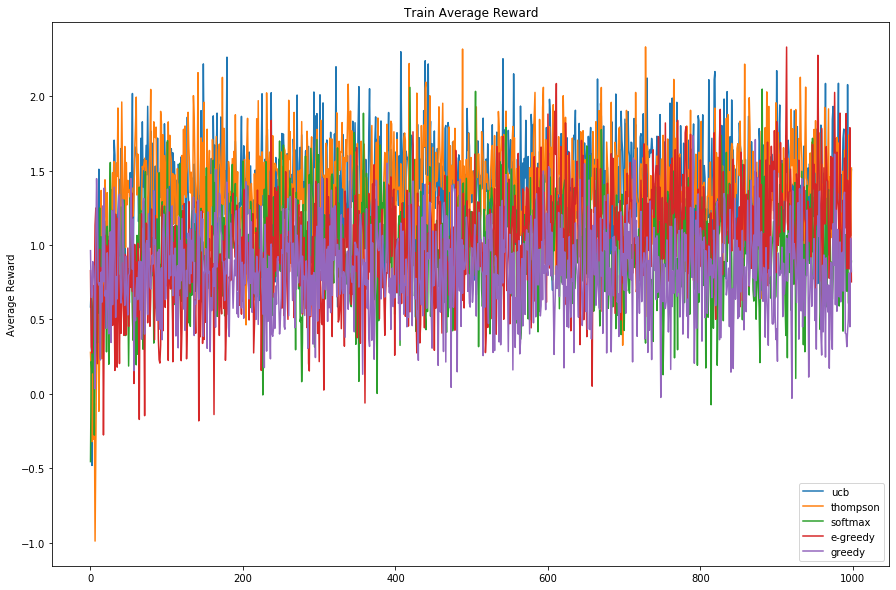

In [0]:
plt.figure(figsize=(15,10))
plt.plot(np.array(C).mean(axis=0))
plt.plot(np.array(G).mean(axis=0))
plt.plot(np.array(K).mean(axis=0))
plt.plot(np.array(O).mean(axis=0))
plt.plot(np.array(S).mean(axis=0))

plt.legend(['ucb', 'thompson', 'softmax', 'e-greedy', 'greedy']);
plt.ylabel("Average Reward");
plt.title("Train Average Reward");

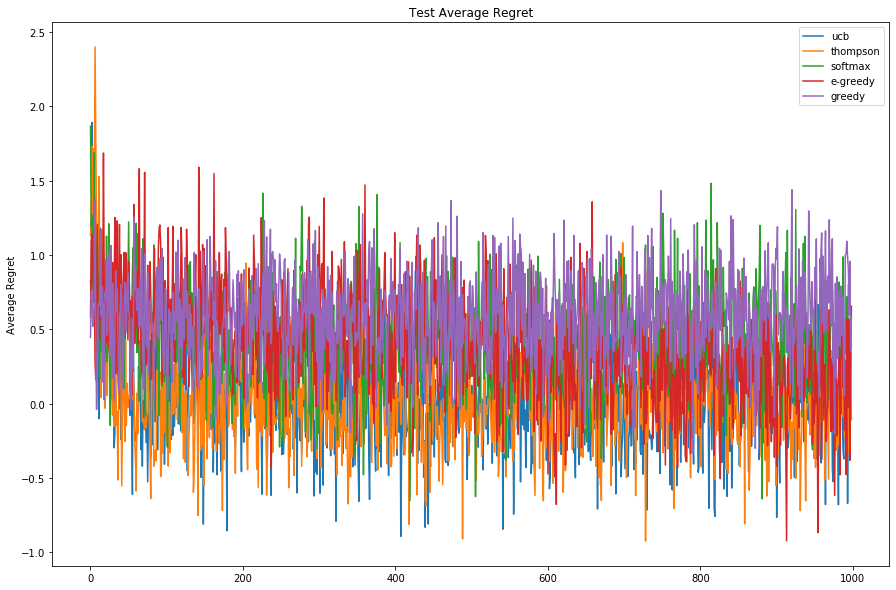

In [0]:
plt.figure(figsize=(15,10))
plt.plot(np.array(D).mean(axis=0))
plt.plot(np.array(H).mean(axis=0))
plt.plot(np.array(L).mean(axis=0))
plt.plot(np.array(P).mean(axis=0))
plt.plot(np.array(T).mean(axis=0))
plt.legend(['ucb', 'thompson', 'softmax', 'e-greedy', 'greedy']);
plt.ylabel("Average Regret");
plt.title("Test Average Regret");

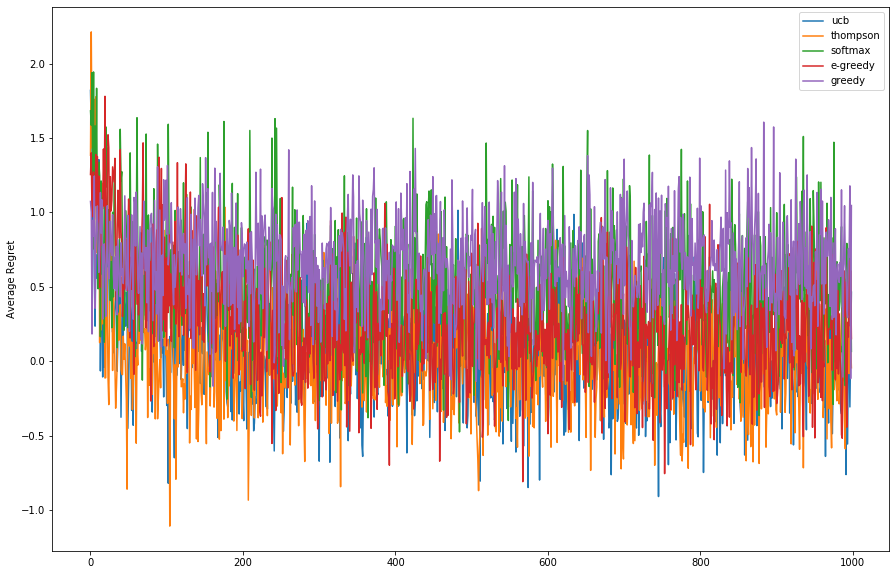

In [0]:
plt.figure(figsize=(15,10))
plt.plot(np.array(d).mean(axis=0))
plt.plot(np.array(h).mean(axis=0))
plt.plot(np.array(l).mean(axis=0))
plt.plot(np.array(p).mean(axis=0))
plt.plot(np.array(t).mean(axis=0))
plt.legend(['ucb', 'thompson', 'softmax', 'e-greedy', 'greedy']);
plt.ylabel("Average Regret");